# Julia for Economists: Packages

**Written for the North American Econometric Society Summer Meeting, June 2016**

**Author**: Chase Coleman

This notebook introduces julia's package manager and some of the packages we have found to be most useful

## Julia's Package Manager

One of the tools that Julia provides is a built in package manager.

All of the package manager commands are within the `Pkg` module, and are called by `Pkg.command(arg)`

Two types of packages

* Registered: Mature package that has some sense of approval from the community
* Unregistered: Less mature package that maybe is still developing basic functionality

### Adding and Removing Registered Packages

Registered packages can be added and removed by using `Pkg.add("PackageName")` and `Pkg.rm("PackageName")`

### Adding and Removing Unregistered Packages

Unregistered packages can be added by using `Pkg.clone("git_repo_url")` and are removed with `Pkg.rm("PackageName")`

### Updating Packages

Packages can be updated to their most recent version by using `Pkg.update()`

Running this command will update:

- Your local `METADATA`, which tracks all versions of registered packages
- Registered packages to latest version
- Unregistered packages to most recent commit on active branch

Doesn't update "dirty" packages (`git status` $\neq$ clean)

## Distributions.jl

A Julia package for probability distributions and associated functions. Particularly, Distributions implements:

* Moments (e.g mean, variance, skewness, and kurtosis), entropy, and other properties
* Probability density/mass functions (pdf) and their logarithm (logpdf)
* Moment generating functions and characteristic functions
* Sampling from population or from a distribution
* Maximum likelihood estimation

In particular, it provides a very natural (and consistent!) way to work with about 70 different distributions.

In [29]:
using Distributions

We will create a standard normal distribution and do a variety of things with it below.

In [30]:
# Create the standard normal distribution
nrv = Normal(0.0, 1.0)

# Get the 1st and 99th percentile
nrv_quantiles = quantile(nrv, [0.01, 0.99])

# Get the value of pdf (and cdf) of the 1st and 99th percentile
nrv_pdf = pdf(nrv, nrv_quantiles)
nrv_cdf = cdf(nrv, nrv_quantiles)

# Sample from the distribution (samples 1 draw from distribution unless specified)
rand(nrv)
rand(nrv, 10)

10-element Array{Float64,1}:
  0.397209
 -1.13898 
 -2.16397 
 -0.711607
 -1.77106 
 -0.330197
  0.900757
 -2.11329 
  1.10637 
 -0.19423 

In [31]:
typeof(nrv)

Distributions.Normal{Float64}

Notice that we can use almost exactly the same code -- We only change the distribution name -- to get these same items from the inverse gamma distribution

In [32]:
ivg = InverseGamma(7.0, 4.0)

# Get the 1st and 99th percentile
ivg_quantiles = quantile(ivg, [0.01, 0.99])

# Get the value of pdf (and cdf) of the 1st and 99th percentile
ivg_pdf = pdf(ivg, ivg_quantiles)
ivg_cdf = cdf(ivg, ivg_quantiles)

# Sample from the distribution (samples 1 draw from distribution unless specified)
rand(ivg)
rand(ivg, 10)

10-element Array{Float64,1}:
 0.485219
 0.367005
 0.695264
 0.556001
 0.984703
 0.697786
 0.353187
 1.15678 
 0.383832
 0.696629

In [33]:
[mean(nrv) mean(ivg)
 std(nrv) std(ivg)
 skewness(nrv) skewness(ivg)
 kurtosis(nrv) kurtosis(ivg)]

4x2 Array{Float64,2}:
 0.0   0.666667
 1.0   0.298142
 0.0   2.23607 
 0.0  12.0     

## Interpolations.jl

This package implements a variety of interpolation schemes for the Julia langauge. It has the goals of ease-of-use, broad algorithmic support, and exceptional performance.

This package is still relatively new. Currently its support is best for B-splines and also supports irregular grids.

In [34]:
using Interpolations

The first thing we need to do is to create an interpolator -- By default this will be defined on [1, Npts]. We need to specify several things:

* Data
* Type of interpolation
  - Order of interpolation
  - Boundary Conditoins
* Where data is located

In [35]:
lb, ub = 0.1, 10.0
x = linspace(lb, ub, 25)
u = log(x)

# Create a BSpline using linear interpolation with data on the grid
lin_itp = interpolate(u, BSpline(Linear()), OnGrid())
qua_itp = interpolate(u, BSpline(Quadratic(Natural())), OnGrid());

We can evaluate the interpolator by using "indexing"

In [36]:
println("Log(x) is: ", round(log(lb), 4))
println("Interpolated value at x is: ", round(lin_itp[lb], 4))

Log(x) is: -2.3026
Interpolated value at x is: -3.7733


What happened??? This is on a grid point, why doesn't it match. This is what I meant when I said it would be defined by default on [1, Npts], we really need to give it the index of the point.

In [37]:
println("Log(x) is: ", round(log(x[1]), 4))
println("Interpolated value at x is: ", round(lin_itp[1], 4))

Log(x) is: -2.3026
Interpolated value at x is: -2.3026


It could get annoying to always be working in indexes for us, but there is a "scaling" feature that allows us to move the domain to where we would like to work.

In [38]:
lin_itp_s = scale(lin_itp, x)
qua_itp_s = scale(qua_itp, x);

In [39]:
println("Log(x) is: ", round(log(lb), 4))
println("Interpolated value at x is: ", round(lin_itp_s[lb], 4))

Log(x) is: -2.3026
Interpolated value at x is: -2.3026


Extrapolation is by default set to linearly extrapolate outside of the bounds, but you can ask it to do

* `Throw` : Throw an error if asked to extrapolate
* `Flat` : Evaluate anything outside grid to the closest grid point
* `Linear` : Linear extrapolate outside of bounds

In [40]:
println(extrapolate(lin_itp_s, Interpolations.Throw())[lb + 0.05])
println(extrapolate(lin_itp_s, Interpolations.Throw())[lb - 0.05])

-2.104508665718352


LoadError: LoadError: BoundsError
while loading In[40], in expression starting on line 2

We can also evaluate the derivatives of our splines

In [41]:
gradient(qua_itp_s, 1.0)

1-element Array{Float64,1}:
 0.950788

Best of all, `Interpolations.jl` is _very_ fast.

In [42]:
n = 10_000_000
fine_grid = linspace(lb, ub, n)

function fill_values(itp::ScaledInterpolation, x::LinSpace)

    # Get number of values and allocate space
    n = length(x)
    interp_values = Array(Float64, n)

    # Fill values
    for i=1:n
        interp_values[i] = itp[x[i]]
    end

    return interp_values
end

fill_values(lin_itp_s, linspace(lb, ub, 100))

@time fill_values(lin_itp_s, fine_grid);

  0.179556 seconds (9 allocations: 76.294 MB, 3.34% gc time)


## NLsolve.jl

The NLsolve package solves systems of nonlinear equations. Formally, if $f$ is a multivariate function, then this package looks for some vector x that satisfies $f(x)=0$.

In [43]:
using NLsolve

Imagine solving the following system of non-linear equations:

\begin{align*}
  x^2 - sin(y) &= 0 \\
  y^2 - cos(x) &= 0
\end{align*}

In [44]:
function f!(xy::Vector, fxy::Vector)
    # Pull out arguments
    x, y = xy

    # Fill fxy
    fxy[1] = x^2 - sin(y)
    fxy[2] = y^2 - cos(x)
end

function g!(xy::Vector, jacxy::Matrix)
    x, y = xy
    # Fill with derivatives of first function
    jacxy[1, 1] = 2*x
    jacxy[1, 2] = -cos(y)

    # Fill off-diagonal
    jacxy[2, 1] = sin(x)
    jacxy[2, 2] = 2*y
end

res = nlsolve(f!, g!, [0.0, 0.0], ftol=1e-10)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0,0.0]
 * Zero: [0.0,0.0]
 * Inf-norm of residuals: 1.000000
 * Iterations: 1000
 * Convergence: false
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-10: false
 * Function Calls (f): 1001
 * Jacobian Calls (df/dx): 1

In [45]:
_fxy = rand(2)
f!(res.zero, _fxy)
_fxy

2-element Array{Float64,1}:
  0.0
 -1.0

## Optim.jl

For many optimization problems `Optim.jl` will do very well -- However, for more complicated problems, we suggest you look into `NLopt.jl` which is based on the stable (and powerful) `NLopt` C library.

In [46]:
using Optim

Consider the following optimization problem

\begin{align*}
  V(x) &= \max_{c_1, c_2, c_3} v(c_1) + \beta v(c_2) + \beta^2 v(c_3) \\
  \text{subject to } & c_1 + c_2 + c_3 = x
\end{align*}

We will transform this to an unconstrained problem (though this is not necessary) to simplify things. In particular, we will substitute our constraint to get

$$c_3 = x - c_1 - c_2$$

`Optim` does minimization, so in order to do the maximization we will minimize the negative of our objective function.

In [47]:
β, x = 0.9, 1.0
v(c) = -exp(-c)
vp(c) = exp(-c)

function objective(β, x, cvec)
    # Unpack input
    c1, c2 = cvec
    c3 = x - c1 - c2

    # Evaluate objective function
    V = v(c1) + β*v(c2) + β*β*v(c3)

    # Negative because we will be minimizing
    return -V
end

objective (generic function with 1 method)

In [48]:
f(cvec) = objective(β, x, cvec)

res_nd = optimize(f, [0.0, 0.0], NelderMead())

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [0.0,0.0]
 * Minimizer: [0.4387055184525176,0.3333012628222983]
 * Minimum: 1.934635e+00
 * Iterations: 25
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < NaN: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 53


In [49]:
println(Optim.minimizer(res_nd))
println(-Optim.minimum(res_nd))

[0.4387055184525176,0.3333012628222983]
-1.9346345390589765


But we have more information, in this case we could also supply a gradient.

In [50]:
function grad!(β, x, cvec, storage::Vector)
    # Unpack input
    c1, c2 = cvec
    c3 = x - c1 - c2

    # Evaluate objective function (Notice - because we are minimizing)
    storage[1] = -(vp(c1) - β*β*vp(c3))
    storage[2] = -(β*vp(c2) - β*β*vp(c3))
end

g!(cvec::Vector, storage::Vector) = grad!(β, x, cvec, storage)

g! (generic function with 2 methods)

In [51]:
res_d = optimize(f, g!, [0.0, 0.0], method=GradientDescent())

Results of Optimization Algorithm
 * Algorithm: Gradient Descent
 * Starting Point: [0.0,0.0]
 * Minimizer: [0.43869384507760445,0.3333333320384733]
 * Minimum: 1.934635e+00
 * Iterations: 11
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 40
 * Gradient Calls: 40

In [52]:
Optim.minimizer(res_d) - Optim.minimizer(res_nd)

2-element Array{Float64,1}:
 -1.16734e-5
  3.20692e-5

In [53]:
# If this is less than 0 then derivative optimization did better
Optim.minimum(res_d) - Optim.minimum(res_nd)

-5.097455790803451e-10

## Plots.jl

There are several plotting packages in the julia ecosystem. [`Plots.jl`](https://github.com/tbreloff/Plots.jl) is attempting to create a unified interface which allows you to create plots using the same commands from any backend The [documentation](http://plots.readthedocs.io/en/latest/) is quite extensive and should provide many examples.

In the interest of full disclosure, I think this package is a still bit of a work in progress, but should eventually (2-3 months out) be the main interface to plotting. I suggest using either the `plotlyjs` or the `pyplot` backend once you do start using it.

In [54]:
using Plots

In [55]:
pyplot()

Plots.PyPlotBackend()

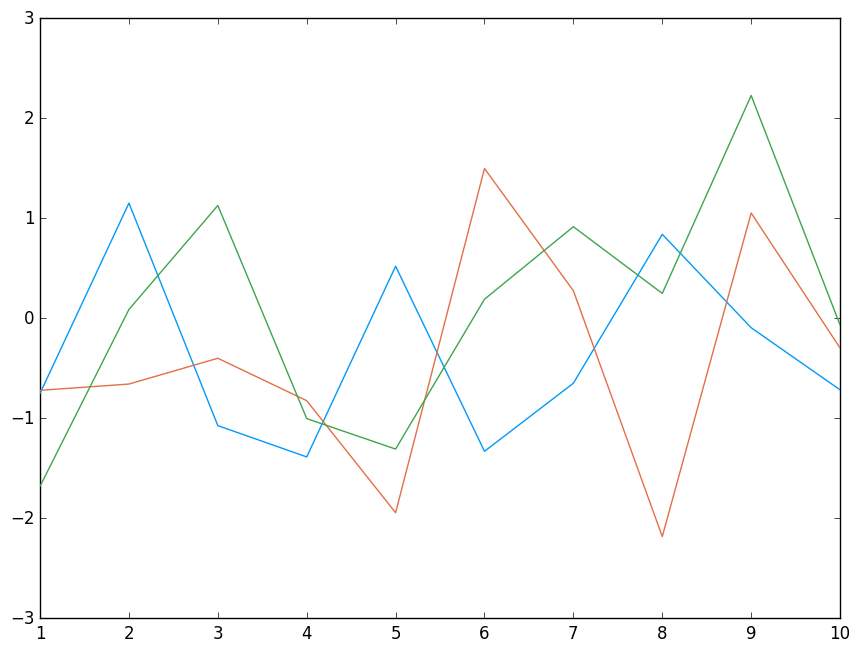


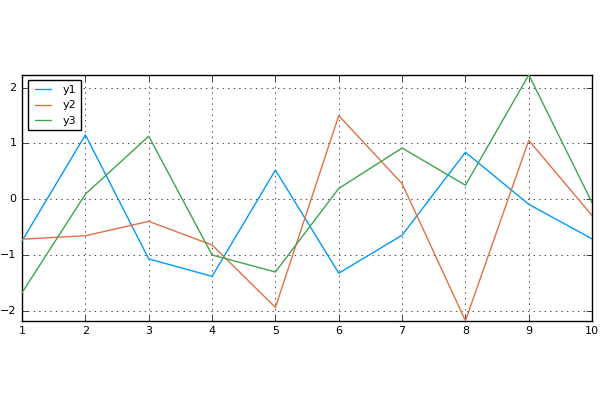

In [56]:
plot(randn(10, 3))

## QuantEcon.jl

`QuantEcon.jl` is a set of general tools that are being developed to help economists do research in Julia. There is already strong support for linear quadratic problems, discrete dynamic programming, and Markov chains.

Will showcase material on Markov chains, but suggest seeing the [lecture site](http://quant-econ.net/) and [notebook gallery](http://quantecon.org/notebooks.html) for examples of how to use other tools within QuantEcon.

In [57]:
using QuantEcon

In [58]:
# Define a transition matrix
Π = [0.9 0.1
     0.1 0.9]

# Define the state values
state_values = [0.5, 1.5]

# Create the Markov chain
mc = MarkovChain(Π, state_values)

Discrete Markov Chain
stochastic matrix of type Array{Float64,2}:
2x2 Array{Float64,2}:
 0.9  0.1
 0.1  0.9


Additionally, one can create Markov chains using either the Rouwenhorst or Tauchen methods for approximating an AR(1).

In [59]:
mc_r = rouwenhorst(5, 0.9, 0.1)

Discrete Markov Chain
stochastic matrix of type Array{Float64,2}:
5x5 Array{Float64,2}:
 0.814506    0.171475  0.0135375  0.000475  6.25e-6   
 0.0428688   0.821275  0.128963   0.006775  0.00011875
 0.00225625  0.085975  0.823537   0.085975  0.00225625
 0.00011875  0.006775  0.128963   0.821275  0.0428688 
 6.25e-6     0.000475  0.0135375  0.171475  0.814506  


Once we have a Markov chain, we can:

* simulate (indices of state or values)
* find stationary distributions
* find periods (and whether it is periodic)
* etc...

In [60]:
simulate(mc, 10)

10x1 Array{Int64,2}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [61]:
simulate_values(mc, 10)

10x1 Array{Float64,2}:
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5

Get stationary distributions

In [62]:
mc_compute_stationary(mc)

2-element Array{Float64,1}:
 0.5
 0.5